## POOL PERL_WETH
Modification2 (Add dsw_oracle fallback_window_size=48h)
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- FALLBACK_WINDOW_SIZE = 48h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

In [4]:
# set rendering mode 'notebook' for interactive view, 'svg' for export
pio.renderers.default = "svg"

In [5]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [6]:
EXPERIMENT_ID = 74

X_NAME = 'PERL'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [7]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [8]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [9]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [10]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [11]:
swaps0_df.head()

id token_in token_out  token_in_amount  token_out_amount_min  \
0   0     WETH      PERL         1.000000                   0.0   
1   2     WETH      PERL         0.330000                   0.0   
2   3     WETH      PERL         0.100000                   0.0   
3   4     WETH      PERL         0.111533                   0.0   
4   5     PERL      WETH         2.058032                   0.0   

   token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
0          0.000000         NaN            NOT_REACHED                NaN   
1        344.539489    0.001320          MITIGATOR_OFF                NaN   
2         19.785837    0.000400          MITIGATOR_OFF                NaN   
3         14.811370    0.000446          MITIGATOR_OFF                NaN   
4          0.017869    0.000071          MITIGATOR_OFF                NaN   

   out_amount_diff  slice_factor  slice_factor_curve               status  \
0              NaN           NaN                 NaN  NOT_ENOUGH_RESERVES   
1              NaN           NaN                 NaN              SUCCESS   
2              NaN           NaN                 NaN              SUCCESS   
3              NaN           NaN                 NaN              SUCCESS   
4              NaN           NaN                 NaN              SUCCESS   

   block_number     block_timestamp transaction_timestamp  \
0           0.0 2020-08-20 07:31:20   2020-08-20 07:31:20   
1           1.0 2020-08-20 07:31:35   2020-08-20 07:31:33   
2          12.0 2020-08-20 07:34:20   2020-08-20 07:34:18   
3          27.0 2020-08-20 07:38:05   2020-08-20 07:37:55   
4          41.0 2020-08-20 07:41:35   2020-08-20 07:41:29   

                                                 txd  \
0  0x259920fbd70f1fb6081890bc61f3d04bb65f7fdb71be...   
1  0xa2579b1d7d65a6196165219ce988979ed0c07a0ed4cb...   
2  0x394e02caf2236dabe102ee16f563e438cc6dc4fa8c44...   
3  0xa7b8b130b5441fbf6aa77fe37c893ec9d9c76ae375e6...   
4  0xb69d1b70c6d0059ff0ec29acf0dc39756dd5c38c90f2...   

                                       sender  \
0  0x21e479e62603a3ea0b6dc687cb86b9938d39a3dd   
1  0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d   
2  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
3  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
4  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   

                                           to  transaction_id  \
0  0x21e479e62603a3ea0b6dc687cb86b9938d39a3dd               0   
1  0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d               2   
2  0x21f1d0daa58f49a0a03855966e79026d2001d00e               3   
3  0xc26da32095985cd03201103bf400fc8058621240               4   
4  0x7a250d5630b4cf539739df2c5dacb4c659f2488d               5   

   reserve_X_before  reserve_Y_before   k_before  price_X_cumulative_before  \
0          0.000000          0.000000   0.000000                          0   
1        450.000000          0.100000  45.000000                          0   
2        105.460511          0.428680  45.208812                          0   
3         85.674674          0.528280  45.260217                          0   
4         70.863304          0.639367  45.307638                          2   

   price_Y_cumulative_before  is_volatility_mitigator_on_before   reserve_X  \
0                          0                              False    0.000000   
1                          0                              False  105.460511   
2                          0                              False   85.674674   
3                      40592                              False   70.863304   
4                      77081                              False   72.921336   

   reserve_Y          k  price_X_cumulative  price_Y_cumulative  \
0   0.000000   0.000000                   0                   0   
1   0.428680  45.208812                   0                   0   
2   0.528280  45.260217                   0               40592   
3   0.639367  45.307638                   2               77081   

In [12]:
swaps0_df.status.value_counts()

SUCCESS                1532
NOT_ENOUGH_RESERVES       1
Name: status, dtype: int64

In [13]:
swaps1_df.status.value_counts()

SUCCESS                             1471
BLOCKED_BY_VOLATILITY_MITIGATION      61
NOT_ENOUGH_RESERVES                    1
Name: status, dtype: int64

In [14]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.03979125896934116


In [15]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                1478
CANT_CONSULT_ORACLE      54
NOT_REACHED               1
Name: mitigator_check_status, dtype: int64

In [16]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.03522504892367906


In [17]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    4
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    4
Name: status, dtype: int64


**61** transactions have been **blocked by the volatility mitigation mechanism**. Only in about **0.04%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle (81.9% before the change)

### Table of transactions blocked by Volatility Mitigation Mechanism

In [18]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp']]

token_in token_out  token_in_amount  token_out_amount  slice_factor  \
2       WETH      PERL         0.100000         19.785837          24.0   
3       WETH      PERL         0.111533         21.600338          26.0   
5       WETH      PERL         0.122975         24.139145          29.0   
7       PERL      WETH       408.979034          0.300092         100.0   
14      PERL      WETH        26.000000          0.069768          23.0   
15      PERL      WETH       261.459316          0.266552         100.0   
22      PERL      WETH      1041.090284          0.045758          26.0   
23      WETH      PERL         0.064811        900.953974          29.0   
24      PERL      WETH      1041.090284          0.045758          26.0   
25      PERL      WETH       958.909716          0.042825          24.0   
26      WETH      PERL         0.081636       1073.576300          36.0   
29      WETH      PERL         0.061683       1430.483870          36.0   
33      WETH      PERL         0.052952       1856.583437          38.0   
35      PERL      WETH       786.000000          0.011996          11.0   
36      WETH      PERL         0.062224       2430.596797          49.0   
38      WETH      PERL         0.057074       2611.449082          49.0   
39      PERL      WETH       700.000000          0.009303           9.0   
41      PERL      WETH       700.000000          0.008100           9.0   
42      WETH      PERL         0.057093       2945.166366          52.0   
44      PERL      WETH       400.000000          0.004376           5.0   
46      WETH      PERL         0.047993       2386.299080          42.0   
48      WETH      PERL         0.044517       2748.220307          43.0   
51      PERL      WETH      4800.000000          0.037396          55.0   
52      WETH      PERL         0.083560       3844.378562          78.0   
53      WETH      PERL         0.050302       2801.286455          47.0   
59      WETH      PERL         0.018237       6812.870978         100.0   
61      WETH      PERL         0.022591       7804.120979         100.0   
62      WETH      PERL         0.001000       7804.120973         100.0   
68      WETH      PERL         0.200000       1058.435694         100.0   
69      PERL      WETH       901.362451          0.015508          72.0   
70      WETH      PERL         0.040000        647.305414         100.0   
71      PERL      WETH       519.364141          0.010842          41.0   
72      WETH      PERL         0.007479        208.040170          20.0   
82      PERL      WETH       657.992820          0.048092         100.0   
83      WETH      PERL         0.080079        255.626082          91.0   
84      PERL      WETH       749.922900          0.050918         100.0   
85      WETH      PERL         0.177691        359.432774         100.0   
86      PERL      WETH       938.458250          0.055618         100.0   
87      PERL      WETH       263.174008          0.028638          49.0   
99      PERL      WETH      1040.190000          0.041403         100.0   
100     WETH      PERL         0.014538        118.584283          21.0   
110     WETH      PERL         0.001124       1885.168900          25.0   
115     WETH      PERL         0.028396       1507.963671         100.0   
116     WETH      PERL         0.009000        824.972278          51.0   
120     WETH      PERL         0.005576        474.162451          28.0   
122     PERL      WETH      2000.000000          0.143516           4.0   
123     WETH      PERL         0.376380       4536.713346          10.0   
124     PERL      WETH      2000.000000          0.143516           4.0   
125     WETH      PERL         0.000900         11.851076           1.0   
128     WETH      PERL         0.534283       6148.359478          14.0   
134     WETH      PERL         0.685481      11565.310267          21.0   
204     PERL      WETH       382.109267          0.121850          78.0   
207     PERL      WETH      2

Text(0.5, 1.0, 'Slice Factor Histogram (blocked transactions)')

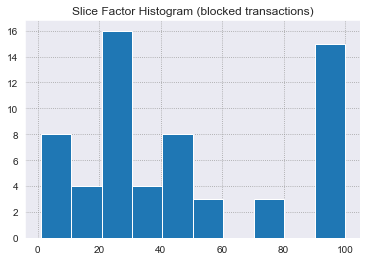

In [19]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('Slice Factor Histogram (blocked transactions)')

**The 4 blocked transactions have a slice factor between 24 and 51%**

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

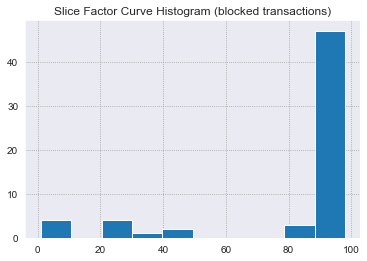

In [20]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

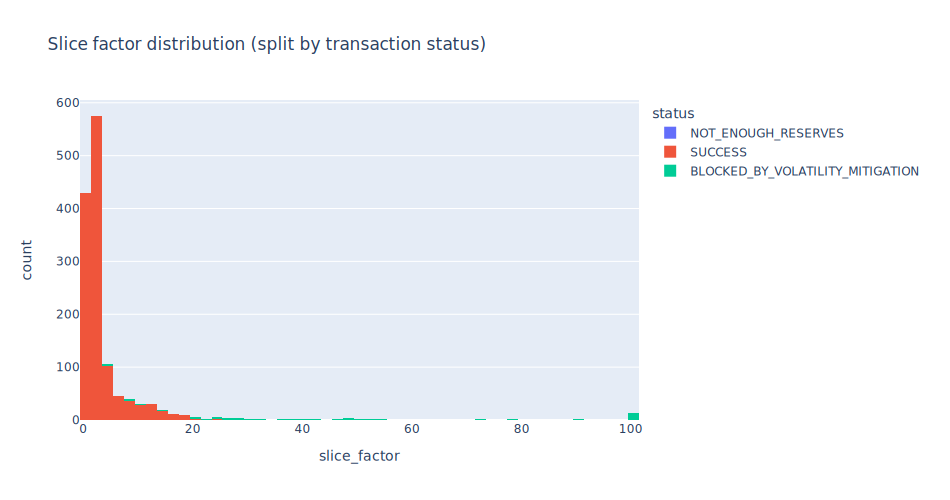

In [21]:
import plotly.express as px

fig = px.histogram(swaps1_df, x="slice_factor", color="status",
                  title='Slice factor distribution (split by transaction status)', width=950, height=500).update_xaxes(categoryorder='total descending')
fig.show()

Note: in the plot above are not included the transactions for which TWAP COUDN'T BE COMPUTED and which weren't checked therefore by volatility mitigation mechanism

**All of the swaps with a slice_factor greater than 25% have been blocked**

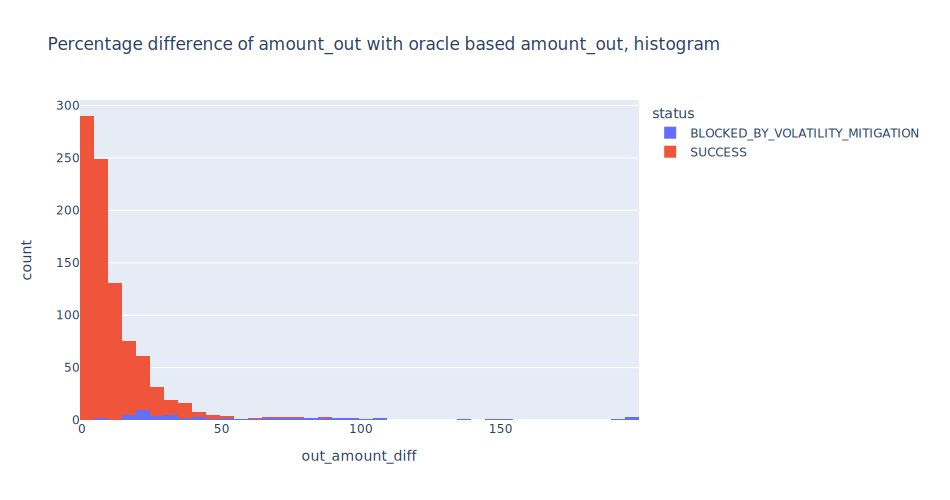

In [22]:
import plotly.express as px

fig = px.histogram(swaps1_df[swaps1_df.slice_factor > 1], x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram', width=950, height=500).update_xaxes(categoryorder='total descending')
fig.show()

In [23]:
swaps1_df.status.value_counts()

SUCCESS                             1471
BLOCKED_BY_VOLATILITY_MITIGATION      61
NOT_ENOUGH_RESERVES                    1
Name: status, dtype: int64

**Most of the transactions have a out_amount_diff greater than 20, only one having out_amount_diff=3**

In [24]:
swaps1_df.head(1000)

id token_in token_out  token_in_amount  token_out_amount_min  \
0       0     WETH      PERL     1.000000e+00                   0.0   
1       2     WETH      PERL     3.300000e-01                   0.0   
2       3     WETH      PERL     1.000000e-01                   0.0   
3       4     WETH      PERL     1.115329e-01                   0.0   
4       5     PERL      WETH     2.058032e+00                   0.0   
5       6     WETH      PERL     1.229751e-01                   0.0   
6       7     PERL      WETH     9.435072e+00                   0.0   
7       8     PERL      WETH     4.089790e+02                   0.0   
8       9     WETH      PERL     1.000000e-02                   0.0   
9      10     WETH      PERL     1.000000e-02                   0.0   
10     11     WETH      PERL     1.000000e-02                   0.0   
11     12     WETH      PERL     2.000000e-02                   0.0   
12     13     WETH      PERL     3.000000e-02                   0.0   
13     14     PERL      WETH     2.000000e+01                   0.0   
14     15     PERL      WETH     2.600000e+01                   0.0   
15     16     PERL      WETH     2.614593e+02                   0.0   
16     17     WETH      PERL     1.000000e-02                   0.0   
17     18     PERL      WETH     3.383795e+02                   0.0   
18     20     PERL      WETH     4.691610e+02                   0.0   
19     21     PERL      WETH     2.654000e+03                   0.0   
20     22     WETH      PERL     7.037796e-02                   0.0   
21     23     WETH      PERL     1.207406e-02                   0.0   
22     24     PERL      WETH     1.041090e+03                   0.0   
23     25     WETH      PERL     6.481079e-02                   0.0   
24     26     PERL      WETH     1.041090e+03                   0.0   
25     27     PERL      WETH     9.589097e+02                   0.0   
26     28     WETH      PERL     8.163583e-02                   0.0   
27     29     PERL      WETH     6.502000e+02                   0.0   
28     30     PERL      WETH     7.000000e+02                   0.0   
29     31     WETH      PERL     6.168286e-02                   0.0   
30     32     WETH      PERL     1.000000e-03                   0.0   
31     33     PERL      WETH     5.820000e+02                   0.0   
32     34     PERL      WETH     7.600000e+02                   0.0   
33     35     WETH      PERL     5.295198e-02                   0.0   
34     36     PERL      WETH     6.540000e+02                   0.0   
35     37     PERL      WETH     7.860000e+02                   0.0   
36     38     WETH      PERL     6.222425e-02                   0.0   
37     39     PERL      WETH     6.000000e+02                   0.0   
38     40     WETH      PERL     5.707387e-02                   0.0   
39     41     PERL      WETH     7.000000e+02                   0.0   
40     42     PERL      WETH     6.000000e+02                   0.0   
41     43     PERL      WETH     7.000000e+02                   0.0   
42     44     WETH      PERL     5.709315e-02                   0.0   
43     45     PERL      WETH     4.000000e+02                   0.0   
44     46     PERL      WETH     4.000000e+02                   0.0   
45     47     WETH      PERL     1.100000e-02                   0.0   
46     48     WETH      PERL     4.799314e-02                   0.0   
47     49     PERL      WETH     9.869613e+02                   0.0   
48     50     WETH      PERL     4.451686e-02                   0.0   
49     51     WETH      PERL     5.000000e-03                   0.0   
50     52     PERL      WETH     7.589461e+01                   0.0   
51     53     PERL      WETH     4.800000e+03                   0.0   
52     54     WETH      PERL     8.356000e-02                   0.0   
53     55     WETH      PERL     5.030152e-02                   0.0   
54     56     PERL      WETH     1.143424e+02                   0.0   
55     57     PERL      WETH   

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

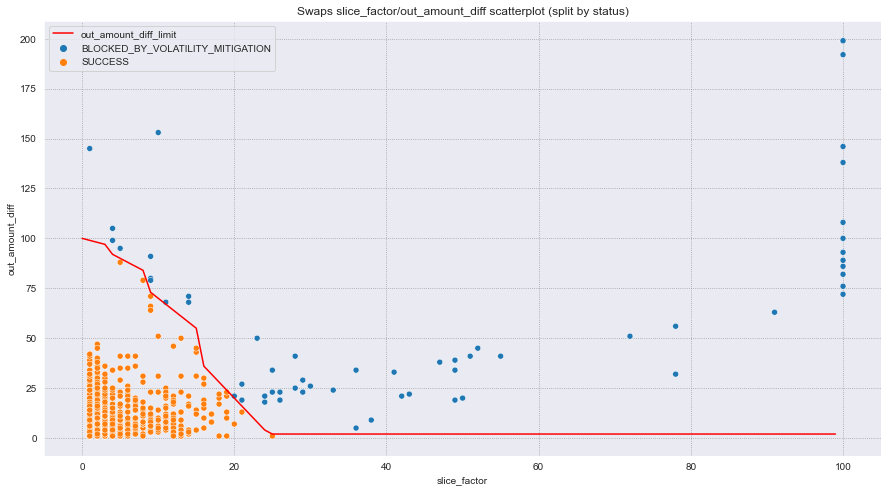

In [25]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

It should be noted that all of the blocked swaps happened before the increase of the reserves.

Text(0, 0.5, 'Count')

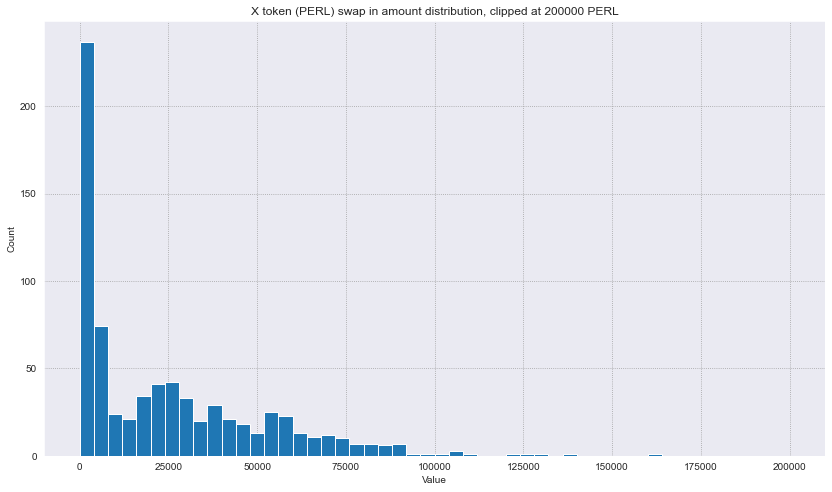

In [29]:
UPPER_LIMIT = 200000


fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
#amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

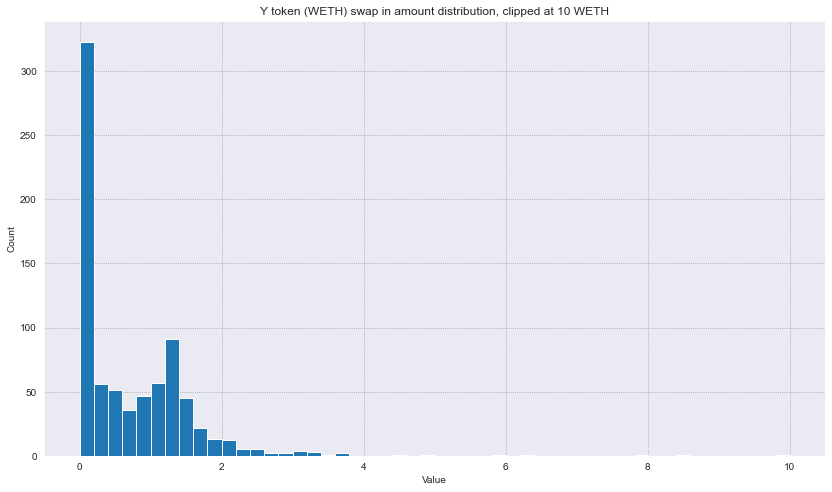

In [32]:
UPPER_LIMIT = 10

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

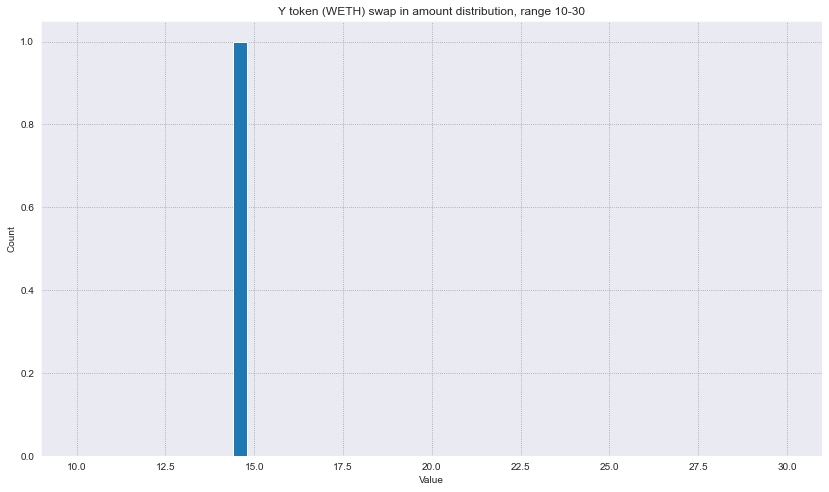

In [34]:
LOWER_LIMIT = 10
UPPER_LIMIT = 30
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

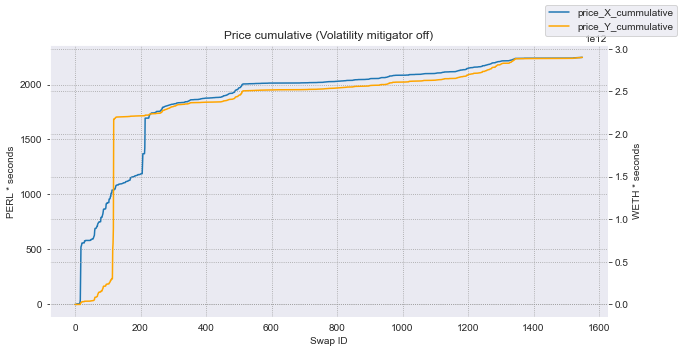

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps0_df.id, swaps0_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

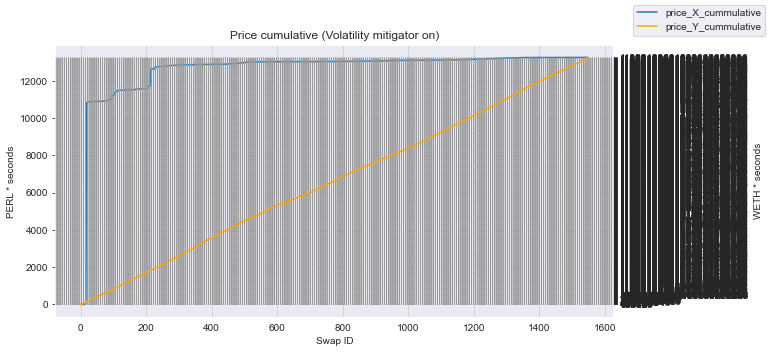

In [42]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative, label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative, label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

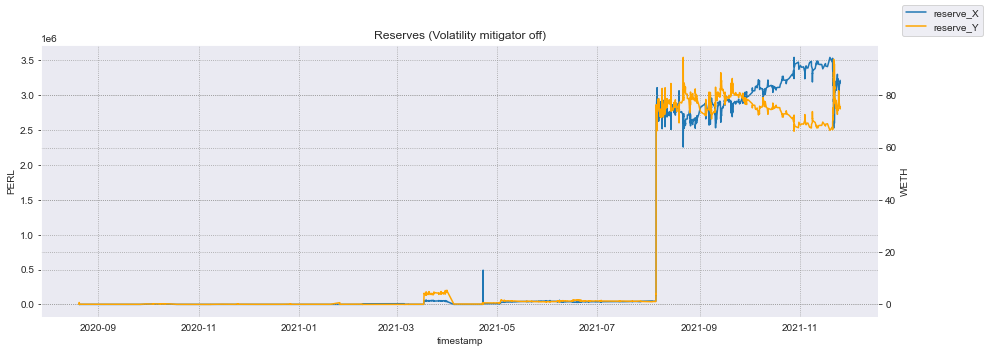

In [43]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

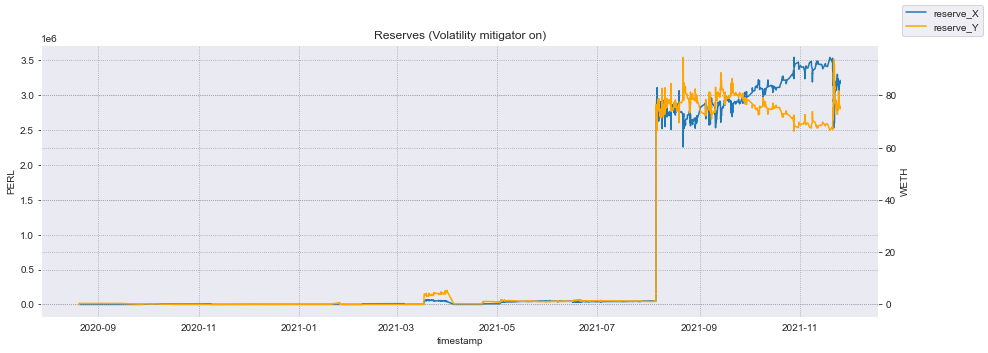

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

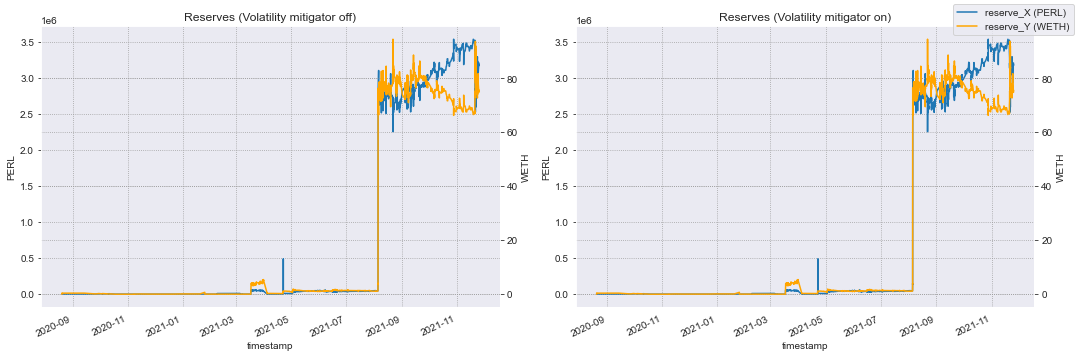

In [34]:

fig, ax = plt.subplots(1, 2,figsize=(15, 5))

ax2 = ax[0].twinx()

ax[0].plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label=f'reserve_X ({X_NAME})')
ax2.plot(swaps0_df.transaction_timestamp, swaps1_df.reserve_Y, label=f'reserve_Y ({Y_NAME})', color='orange')

ax[0].set_xlabel('timestamp')
ax[0].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[0].set_title('Reserves (Volatility mitigator off)')

ax2 = ax[1].twinx()


ax[1].plot(swaps1_df.transaction_timestamp, swaps0_df.reserve_X, )
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, color='orange')

ax[1].set_xlabel('timestamp')
ax[1].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[1].set_title('Reserves (Volatility mitigator on)')

fig.autofmt_xdate(rotation=25)

fig.legend()
fig.tight_layout()

**The variation of reserves over time is very similar at the first glance with and without the volatility mitigator**

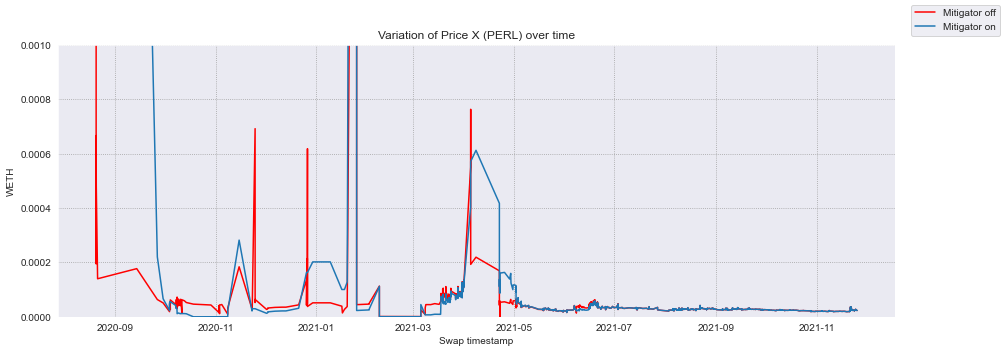

In [46]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 1e-3)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

In [41]:
swaps1_df.iloc[:1000]

id token_in token_out  token_in_amount  token_out_amount_min  \
0       0     WETH      PERL     1.000000e+00                   0.0   
1       2     WETH      PERL     3.300000e-01                   0.0   
2       3     WETH      PERL     1.000000e-01                   0.0   
3       4     WETH      PERL     1.115329e-01                   0.0   
4       5     PERL      WETH     2.058032e+00                   0.0   
5       6     WETH      PERL     1.229751e-01                   0.0   
6       7     PERL      WETH     9.435072e+00                   0.0   
7       8     PERL      WETH     4.089790e+02                   0.0   
8       9     WETH      PERL     1.000000e-02                   0.0   
9      10     WETH      PERL     1.000000e-02                   0.0   
10     11     WETH      PERL     1.000000e-02                   0.0   
11     12     WETH      PERL     2.000000e-02                   0.0   
12     13     WETH      PERL     3.000000e-02                   0.0   
13     14     PERL      WETH     2.000000e+01                   0.0   
14     15     PERL      WETH     2.600000e+01                   0.0   
15     16     PERL      WETH     2.614593e+02                   0.0   
16     17     WETH      PERL     1.000000e-02                   0.0   
17     18     PERL      WETH     3.383795e+02                   0.0   
18     20     PERL      WETH     4.691610e+02                   0.0   
19     21     PERL      WETH     2.654000e+03                   0.0   
20     22     WETH      PERL     7.037796e-02                   0.0   
21     23     WETH      PERL     1.207406e-02                   0.0   
22     24     PERL      WETH     1.041090e+03                   0.0   
23     25     WETH      PERL     6.481079e-02                   0.0   
24     26     PERL      WETH     1.041090e+03                   0.0   
25     27     PERL      WETH     9.589097e+02                   0.0   
26     28     WETH      PERL     8.163583e-02                   0.0   
27     29     PERL      WETH     6.502000e+02                   0.0   
28     30     PERL      WETH     7.000000e+02                   0.0   
29     31     WETH      PERL     6.168286e-02                   0.0   
30     32     WETH      PERL     1.000000e-03                   0.0   
31     33     PERL      WETH     5.820000e+02                   0.0   
32     34     PERL      WETH     7.600000e+02                   0.0   
33     35     WETH      PERL     5.295198e-02                   0.0   
34     36     PERL      WETH     6.540000e+02                   0.0   
35     37     PERL      WETH     7.860000e+02                   0.0   
36     38     WETH      PERL     6.222425e-02                   0.0   
37     39     PERL      WETH     6.000000e+02                   0.0   
38     40     WETH      PERL     5.707387e-02                   0.0   
39     41     PERL      WETH     7.000000e+02                   0.0   
40     42     PERL      WETH     6.000000e+02                   0.0   
41     43     PERL      WETH     7.000000e+02                   0.0   
42     44     WETH      PERL     5.709315e-02                   0.0   
43     45     PERL      WETH     4.000000e+02                   0.0   
44     46     PERL      WETH     4.000000e+02                   0.0   
45     47     WETH      PERL     1.100000e-02                   0.0   
46     48     WETH      PERL     4.799314e-02                   0.0   
47     49     PERL      WETH     9.869613e+02                   0.0   
48     50     WETH      PERL     4.451686e-02                   0.0   
49     51     WETH      PERL     5.000000e-03                   0.0   
50     52     PERL      WETH     7.589461e+01                   0.0   
51     53     PERL      WETH     4.800000e+03                   0.0   
52     54     WETH      PERL     8.356000e-02                   0.0   
53     55     WETH      PERL     5.030152e-02                   0.0   
54     56     PERL      WETH     1.143424e+02                   0.0   
55     57     PERL      WETH   

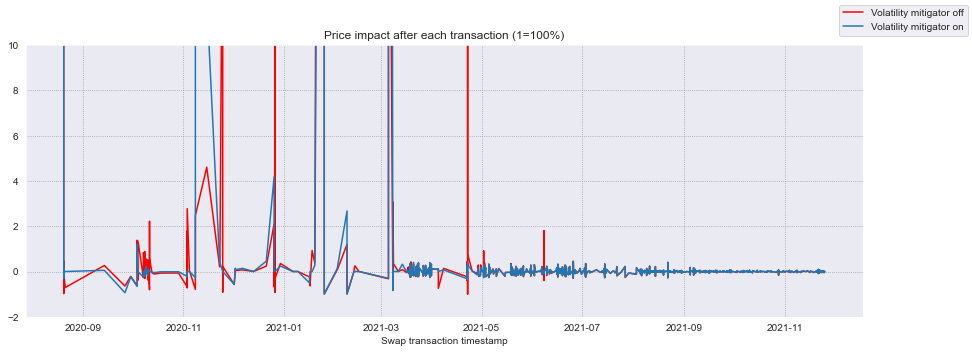

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-2, 10)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**Most of the spikes (consecutive increases/decreases of price), are caused by MEV-bot sandwich attacks.**

(18494.313425925928, 18956.355972222223)

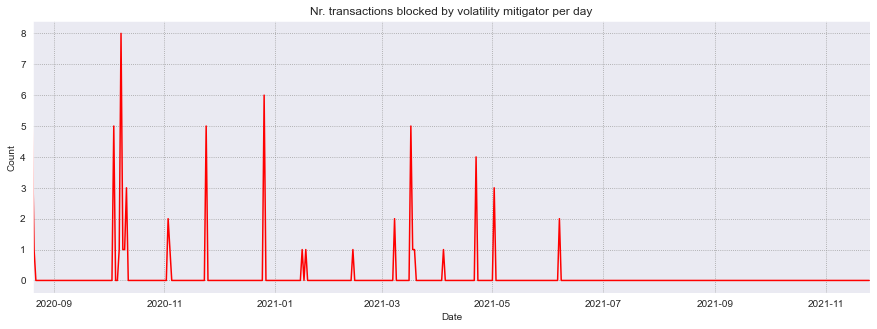

In [154]:
swaps1_indexed_df = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].copy()
swaps1_indexed_df.index = swaps1_indexed_df.transaction_timestamp
swaps1_indexed_df.loc[swaps1_df.transaction_timestamp.min()] = np.nan
swaps1_indexed_df.loc[swaps1_df.transaction_timestamp.max()] = np.nan
resampled24 = swaps1_indexed_df.resample('24h').size()
resampled24[0] -= 1
resampled24[-1] -= 1
resampled24.head()

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=resampled24.index, y=resampled24.values, linestyle='solid', color='red', marker=None,)

ax.set_title("Nr. transactions blocked by volatility mitigator per day")
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.set_xlim(swaps1_df.transaction_timestamp.min(), swaps1_df.transaction_timestamp.max())

All of the swaps that were blocked happened before the significant increase in the reserves

In [49]:
swaps1_df[swaps1_df.price_diff > 0.5]

id token_in token_out  token_in_amount  token_out_amount_min  \
1      2     WETH      PERL         0.330000                   0.0   
20    22     WETH      PERL         0.070378                   0.0   
64    68     WETH      PERL         0.020000                   0.0   
65    69     WETH      PERL         0.059076                   0.0   
81    87     WETH      PERL         0.049563                   0.0   
102  108     WETH      PERL         0.624638                   0.0   
107  113     WETH      PERL         0.034012                   0.0   
113  119     WETH      PERL         0.040371                   0.0   

     token_out_amount  system_fee mitigator_check_status  oracle_amount_out  \
1          344.539489    0.001320    CANT_CONSULT_ORACLE                NaN   
20        2070.072098    0.000282    CANT_CONSULT_ORACLE                NaN   
64        8148.686942    0.000080    CANT_CONSULT_ORACLE                NaN   
65         750.803117    0.000236    CANT_CONSULT_ORACLE                NaN   
81         686.580107    0.000198    CANT_CONSULT_ORACLE                NaN   
102        540.649953    0.002499    CANT_CONSULT_ORACLE                NaN   
107        576.777998    0.000136    CANT_CONSULT_ORACLE                NaN   
113      10398.765540    0.000161    CANT_CONSULT_ORACLE                NaN   

     out_amount_diff  slice_factor  slice_factor_curve   status  block_number  \
1                NaN           NaN                 NaN  SUCCESS           1.0   
20               NaN           NaN                 NaN  SUCCESS      256743.0   
64               NaN           NaN                 NaN  SUCCESS      460402.0   
65               NaN           NaN                 NaN  SUCCESS      500151.0   
81               NaN           NaN                 NaN  SUCCESS      735771.0   
102              NaN           NaN                 NaN  SUCCESS      911226.0   
107              NaN           NaN                 NaN  SUCCESS      990738.0   
113              NaN           NaN                 NaN  SUCCESS     1135745.0   

        block_timestamp transaction_timestamp  \
1   2020-08-20 07:31:35   2020-08-20 07:31:33   
20  2020-10-03 21:17:05   2020-10-03 21:17:02   
64  2020-11-08 05:51:50   2020-11-08 05:51:41   
65  2020-11-15 03:29:05   2020-11-15 03:28:53   
81  2020-12-26 01:14:05   2020-12-26 01:13:58   
102 2021-01-25 12:17:50   2021-01-25 12:17:45   
107 2021-02-08 07:35:50   2021-02-08 07:35:41   
113 2021-03-05 11:47:35   2021-03-05 11:47:22   

                                                   txd  \
1    0xa2579b1d7d65a6196165219ce988979ed0c07a0ed4cb...   
20   0x622d6edb69537316f1fababf16bb4e6bb04b3a18d171...   
64   0xf907e4417060e1356f4a5ee5a640b74ef255a26bea08...   
65   0xea893905a55dc9a7186f40bc08ddfebb5502d2d3d322...   
81   0xd3bccd1b9c2e04f3c6943e4b78251e280a91ea75f244...   
102  0x842aa427c21b36158502ac3d21a35f88cb1e38373f4a...   
107  0xa3eeb3161a0e01c281fb76c418b8d5ca67f3143c1645...   
113  0x4c4f7e2c5b5266c4672d96b71793a9ca857b9e387cc2...   

                                         sender  \
1    0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d   
20   0x66f35c9adf56f148cac033db9bf8e641ff93888a   
64   0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
65   0x0000000000007f150bd6f54c40a34d7c3d5e9f56   
81   0xdef1c0ded9bec7f1a1670819833240f027b25eff   
102  0x7a250d5630b4cf539739df2c5dacb4c659f2488d   
107  0x393e0000cc906900d800a91b9830380028eebfc6   
113  0x0000000094acb89a43eac2fbb3a07973efc2435c   

                                             to  transaction_id  \
1    0x90b98c3db94f6d2a088a3d7e4c86e15a39f8ee0d               2   
20   0x66f35c9adf56f148cac033db9bf8e641ff93888a              22   
64   0xd1c300000000b961df238700ef00600097000049              68   
65   0x0000000000007f150bd6f54c40a34d7c3d5e9f56              69   
81   0x74de5d4fcbf63e00296fd95d33236b9794016631              87   
102  0x0efb068354c10c070ddd64a0e8eaf8f054df7e26             108   
107  0x393e0000cc906900d800a91b98303800

After applying the modification, the nubmer of transactions with a significant price impact has decreased from 33 to 8